### DBC problem - FEniCS

(Brittle) Fracture Mechanics course MU5MES02 - S1 - P1

$\underline{\text{Students name}}$ : Ackbarrally Faiz & Duvivier Valentin
    
$\underline{\text{Under the direction of}}$ : Maurini Corrado
    
$\underline{\text{Last modified}}$ : 22/11/2021

$\underline{Abstract}$ : This report is part of the Homework of the Fracture course. It's conducted in order to study numerically a crack in a DCB structure and derive the displacement and force along time.

It has been done excluesively by Ackbarrally Faiz and Duvivier Valentin, and so we engage ourselves by confirming that no part of the following have been plagiarized in anyway.

### Presentation of the problem

$\underline{Material}$

The system is made of an isotropic homogeneous linear elastic material. We mainly work with adimensionnate variables but one can get physical values back mutliplying final result by adequate multiplier.

$\underline{Domain}$

The structure in this problem is a Double Cantiliver Beams (DCB).

At last, symmetries of the problem in terms of geometry, material properties and load allow to perform the study on only half of the part, namely of subpart located in the half space $x_2>0$.

Here is a visual of the system :

<img src="DCB_1.png"  width="700" />

Let's now make a few stidies on this sytem.

### Code

#### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import dolfin 
import mshr
import ufl
import mshr

%config Completer.use_jedi = False
%config IPCompleter.greedy = True

#### Mesh

In [2]:
# ----
# MESH
# ----

# Elasticity parameters
E = 1.
nu = 0.3
# Elasticity parameters
mu = E/(2*(1.0 + nu)) # lame 1 (plane-strain)
lmbda = E*nu/((1.0 + nu)*(1.0 -2.0*nu)) # lame 2 (plane-strain) 
    
# Shape mesh : just for indication, repeated to run loops
Lx = 10. #length beam
H1 = 1.  #left height
H2 = 2.  #right height

Lc = Lx/1.5 #length crack
n_div=30; n_ref=5; R_ref=0.5 # to build mesh    

#### Functions

In [3]:
def generate_mesh(Lc=4, n_div=30, n_ref=5, R_ref=0.5, Lx=10, H1=1, H2=1):
    
    """
    Generate a polygonal mesh with:
        - Lc : crack length
        - n_div : number of divisions on the largest side
        - n_ref : number of refinements around the crack
        - r_ref : Radius for refinement around the crack
        - Lx : Length
        - H1 : Left side
        - H2 : Rigth side
    """
    
    p0 = dolfin.Point(0,0)
    pc = dolfin.Point(Lc,0)
    p1 = dolfin.Point(Lx,0)
    p2 = dolfin.Point(Lx,H2)
    p3 = dolfin.Point(0,H1)
    
    geom = mshr.Polygon([p0, pc, p1, p2, p3])
    mesh = mshr.generate_mesh(geom, n_div)
    
    for i in range(n_ref):
        cell_markers = dolfin.MeshFunction("bool", mesh, mesh.topology().dim())
        cell_markers.set_all(False)
        for cell in dolfin.cells(mesh):
            if cell.midpoint().distance(pc) < R_ref :
                cell_markers[cell] = True
        mesh = dolfin.refine(mesh, cell_markers)
    
    return mesh 

# -------------------------------------------------

def eps(u):
    return dolfin.sym(dolfin.grad(u))

def sigma(epsilon):
    E = 1.
    nu = 0.3
    # Elasticity parameters
    mu = E/(2*(1.0 + nu)) # lame 1 (plane-strain)
    lmbda = E*nu/((1.0 + nu)*(1.0 -2.0*nu)) # lame 2 (plane-strain) 
    
    return  2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(2)

# -------------------------------------------------

def dcb_solver(Lc=4, n_div=30, n_ref=5, R_ref=.5, Lx=10, H1=1., H2=1.):
    
    """ Function creating mesh and returning displacement solution 
    together with energy (energy release ??) given geometrical mesh.
    
    Note : we apply a verical lift to the left under the form of a 
    vertical unit displacement.
    """
    
    mesh = generate_mesh(Lc=Lc, n_div=n_div, n_ref=n_ref, R_ref=R_ref, Lx=Lx, H1=H1, H2=H2)
    
    V  = dolfin.VectorFunctionSpace(mesh, "Lagrange", 2)
    
    # Boundary conditions
    u0 = dolfin.Constant(0.)
    u1 = dolfin.Constant(1.)
    
    bc_bottom = dolfin.DirichletBC(V.sub(1), u0, f"on_boundary & near(x[1],0) && x[0] > {Lc}")
    bc_left   = dolfin.DirichletBC(V.sub(1), u1,  "on_boundary & near(x[0],0)"               )
    bc_right  = dolfin.DirichletBC(V.sub(0), u0, f"on_boundary & near(x[0],{Lx})"            )
    bcs = [bc_right, bc_bottom, bc_left]
    
    # Variational formulation of the problem 
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # bilinear form
    a = dolfin.inner(sigma(eps(u)), eps(v)) * dolfin.dx 
    
    # linear form
    
    # Bulk load 
    bulk_load = dolfin.Constant((0.,0.))
    L = dolfin.inner(bulk_load, v) * dolfin.dx
    
    A = dolfin.assemble(a)
    b = dolfin.assemble(L)
    for bc in bcs:
        bc.apply(A, b)
    
    usol = dolfin.Function(V)
    dolfin.solve(A, usol.vector(), b)
    
    energy = 0.5 * dolfin.assemble(dolfin.inner(sigma(eps(usol)), eps(usol)) * dolfin.dx)
    
    return usol, 2*energy # *2 as 2 beams

def create_theta_field(mesh, Lcrack, R_int, R_ext):

    """ Function creating sub_domaines where one wants to 
    refine the mesh (around crack and interaction crack/structure)
    """
    
    V_theta = dolfin.FunctionSpace(mesh, "P", 1)

    theta   = dolfin.Function(V_theta)
    theta_test  = dolfin.TestFunction(V_theta)
    theta_trial = dolfin.TrialFunction(V_theta)
   
    def inner_domain(x):
        return np.sqrt((x[0]-Lc)**2 + x[1]**2) < R_int
    
    def outer_domain(x):
        return np.sqrt((x[0]-Lc)**2 + x[1]**2) > R_ext
    
    one  = dolfin.Function(V_theta)
    zero = dolfin.Function(V_theta)
    one.interpolate(dolfin.Constant(1.))
    
    bc_0 = dolfin.DirichletBC(V_theta, zero, outer_domain)
    bc_1 = dolfin.DirichletBC(V_theta, one, inner_domain)
        
    bcs  = [bc_0, bc_1]
    
    a    = ufl.dot(ufl.grad(theta_trial), ufl.grad(theta_test)) * ufl.dx
    L    = zero * theta_test * ufl.dx 
    A, b = dolfin.assemble_system(a, L, bcs)
    dolfin.solve(A, theta.vector(), b)
    
    return theta

## Questions

### Q1
Let us denote by $P$ and $G$ the dimensionless potential energy and the dimensionless energy release rate obtained for a Young modulus $E=1$ and an applied displacement $t=1$ on a mesh with the same aspect ratio as the original geometry but with thickness at the left-end $H=1$. Show that the dimensional value of the energy $P_\mathrm{dimensional}$ and the energy release rate $G_\mathrm{dimensional}$ for a structure of thickness at the left-end $H$, Young modulus $E$ with applied displacement $t$ and with a depth $b$ are given by
$$
P_\mathrm{dimensional}={E \, b\, t^2}  P_{adim},\quad G_\mathrm{dimensional}=\frac{E\,b\, t^2}{H} G_{adim}
$$
This will allows us to perform, without loss of generality, the numerical simulations on a mesh of thickness at the left-hand $H=1$ with $t=1$ and $E=1$.

##### a.

$\textit{We have from by integration :}$

$$P=\dfrac{q^2.E.b.H_1^3}{24.l^3} \times \dfrac{1}{coeff}$$

$\textit{and so by adimensionnalisation :}$

$$P=\left(E.b.q^2\right)\left(\dfrac{H_1}{l}\right)^3 \times \dfrac{1}{24.coeff}$$

$\textit{and so}$ $P_{adim} = \left(\dfrac{H_1}{l}\right)^3 \times \dfrac{1}{24.coeff}$

coeff is the coefficient associated to our group (given we considered $\frac{H_2}{H_1}=2.2$). 

In our case $coeff\approx0.178505$

##### b.

$\textit{We have from by derivation :}$

$$G = \dfrac{E.b.H_1^3.q^2}{8.l^4}\times \dfrac{1}{coeff}$$

$\textit{and so by adimensionnalisation :}$

$$G = \dfrac{E.b.q^2}{H_1} \times \left(\dfrac{H_1}{l}\right)^4 \times \dfrac{1}{8.coeff}$$

$\textit{and so}$ $G_{adim} = \left(\dfrac{H_1}{l}\right)^4 \times \dfrac{1}{8.coeff}$

### Q2 
Consider the following geometry and mesh, for which we provide a solver of the elastic problem below (`dcb_solver`) with a value of the thickness at the right-hand $H_2$ given for your group (you should replace with this value the $H_2=1$ in the code below). Determine the dimensionless energy release rate $G$ for $L=4.$ using the following methods:

 a. Crack opening displacement
 
 b. G-$\theta$
 

#### Crack opening displacement method

In [4]:
Lc   = 4
Lx   = 12

mesh = generate_mesh(Lc=Lc, n_div=30, n_ref=5, R_ref=.5, Lx=Lx, H1=1., H2=2.)
dolfin.plot(mesh)

plt.plot([0, Lc],[0, 0], "-r") # plot crack
plt.show()

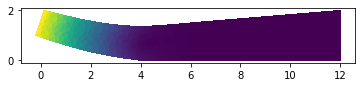

In [5]:
# Crack opening displacement method
H2 = 1.
usol_H2_1, P_opening_H2_1 = dcb_solver(Lc=4., n_div=30, n_ref=5, R_ref=.5, Lx=12., H1=1., H2=H2)

H2 = 2.
usol, P_opening = dcb_solver(Lc=4., n_div=30, n_ref=5, R_ref=.5, Lx=12., H1=1., H2=H2)

dolfin.plot(usol, mode="displacement")

To compare analytical and numerical potential energy provides an object of comparison to check whether we implemented well.

It's especially relevant to check if:
* first code works
* and then that analytical solution for $H_2=2$ is good

In [6]:
coeff = 0.178505 # approximation # ==result integral when calculating P

In [7]:
b = 1.; H1 = 1.; t = 1.

# *2 as 2 beams
P_ana_H2_1 = 2* E*b*H1**3 * t**2 / (8 *Lc**3)
P_ana = 2* E*b*H1**3 * t**2 / (24*Lc**3 * coeff) #calculated by hand and validated by Mathematica
# for calculation details, just remember then we first remove x^2 terms through log and then have integrations of 1/x^2 and 1/x^3 which are easy.

print('\nWhen H1=H2 :')

print('\npotential energy P_ana = {:.7f} J'.format(P_ana_H2_1))
print('potential energy P_num = {:.7f} J'.format(P_opening_H2_1)) #2* as 2 beams to account for

rel_err = np.abs(P_ana_H2_1 - P_opening_H2_1) / P_ana_H2_1
print('\nIt comes a relative error err={:.1f}%'.format(rel_err * 100))

print('\n# -------------------\n')

print('\nWhen H2=2 x H1 :')

print('\npotential energy P_ana_H2_2 = {:.7f} J'.format(P_ana))
print('potential energy P_num_H2_2 = {:.7f} J'.format(P_opening)) #2* as 2 beams to account for

rel_err = np.abs(P_ana - P_opening) / P_ana
print('\nIt comes a relative error err={:.1f}%'.format(rel_err * 100))


When H1=H2 :

potential energy P_ana = 0.0039062 J
potential energy P_num = 0.0026868 J

It comes a relative error err=31.2%

# -------------------


When H2=2 x H1 :

potential energy P_ana_H2_2 = 0.0072944 J
potential energy P_num_H2_2 = 0.0049662 J

It comes a relative error err=31.9%


#### G calculation 

To get G one must get $K_I$ factor and deduce G from
$$G = K_I^2 \times \frac{(1 - \nu^2)}{E}$$

To get $K_I$ :

In [8]:
H1  = 1.
r   = np.linspace(.001, .1, 50)
L_r = Lc - r # positions around crack
us  = np.array([usol(_, 0)[1] for _ in L_r])

plt.plot(L_r, us, '.')

plt.title(r'$u_y|_{y=0}$ close to crack')
plt.xlabel('Lc(x)')
plt.ylabel(r'$u_y|_{y=0}$')

plt.grid(True)

# -------

k = (3 - 4*float(nu)) # plane strain
K_I_test = 2 * us * float(mu) / ((1 + k) * np.sqrt(r / (2*np.pi))) ## / L_r ??????

plt.figure()

plt.semilogx(r, K_I_test, 'r.')

plt.title(r'$K_I$ close to crack')
plt.xlabel('Lc(x)')
plt.ylabel(r'$K_I$')

plt.grid(True)

It is more relevant (i.e. more physical) to have K_I(r) or K_I(L_r) ??

In [9]:
K_I = np.min(K_I_test)
print('\nK_I = {:.3f}'.format(K_I))

G_opening = K_I**2 * (1 - float(nu)**2) / float(E)
print('\nIt then comes G={:.4f}'.format(G_opening))


K_I = 0.056

It then comes G=0.0029


#### G-$\theta$ method

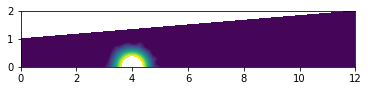

In [10]:
# Implementation method - Solving

V     = usol.function_space()
mesh  = V.mesh()

Lc    = 4. # same than analytical formulation ??
R_ext = Lc / 5
R_int = R_ext / 2 #Lc / (2a)

theta = create_theta_field(mesh, Lc, R_int, R_ext)

plt.figure()
dolfin.plot(theta)

# -------------------

e_1 = ufl.as_vector([1,0])
theta_v = theta * e_1

# may be printed
plt.figure()
dolfin.plot(.1*theta_v, mode='displacement')

Last graph shows theta along $\underline{e}_1$. Then with mode = displacement we see path of crack (i.e. crack propagation).

We center theta half-circles around crack, and as it moves, theta moves.

##### Post process - G calculation

In [12]:
eps_sol   = eps(usol)
sigma_sol = sigma(eps_sol)

W = ufl.inner(sigma_sol, eps_sol)

first_term  = dolfin.assemble(ufl.inner(sigma_sol, ufl.grad(usol) * ufl.grad(theta_v)) * dolfin.dx)
second_term = - .5*dolfin.assemble(W * ufl.div(theta_v) * dolfin.dx)

G_theta = 2*(first_term + second_term)

# ------------------
# G_ana :

G_ana = (H1/Lc**4) * 1/(8*coeff) # to be multiplied by E.b.H1^3.q^2

# ------------------

print('\nRelease energy for G-theta method is G = {:.4f} J'.format(G_theta))

def compute_ERR(var1, var2, var3, option):
    
    """ Function returning absolute value of aboslute/relative 
    error between 2 variables given these 2 variables and ana-
    lytical solution.
    
    Note : for relative error, put variable to test first.
    """
    
    if option == "relative":
        print('Relative error var1 = {:.1f}%'.format(100 * np.abs(var1 - var3)/np.abs(var3)))

    elif option == "absolute":
        print('Absolute var1/var2 = {:.4f}%'.format(np.abs(var1 - var2)))

    else:
        print('error in option : must either choose i. relative or ii. absolute')

print('\nError calculations :')

print('\nG-theta:')
compute_ERR(G_theta, G_opening, G_ana, "relative") # prints absolute error

print('\nG-disp:')
compute_ERR(G_opening, G_theta, G_ana, "relative") # prints absolute error

print('\nG_ana = {:.5f}'.format(G_ana))


Release energy for G-theta method is G = 0.0025 J

Error calculations :

G-theta:
Relative error var1 = 9.2%

G-disp:
Relative error var1 = 6.1%

G_ana = 0.00274


**We here have the relative errors of numerical G with respect to analytical solution.**

### Q3 
For the following numerical values (PMMA) $E = 2.4\,GPa$ , 
$H = 8\,mm$, $G_c=1.4 Nm^{-1}$, and considering a plate with a pre-existing crack 
$\ell_0 = 32\,mm$, determine the critical displacement $t_c$ at which the crack start propagating.

We get crack expansion when $\ell$ no longer is equal to $\ell_0$ so when :
    
$$t \gt t_c = \sqrt{\frac{8.G_c.coeff}{E.b.H_1^3}}l_c^2 \approx 3.6E^{-5}~s$$

From adimensionalisation process developped in Q1, we may recover associated potential energy and energy release rate :
    
$$P = E t_c^2 \times P_{code} ~~ and ~~ G = \frac{E t_c^2}{H} \times G_{code}$$
as $b$ is held at $b=1$

In [13]:
# It comes :
E_pmma   = 2.4*10**9
H_ppma   = 8E-3
G_c_ppma = 1.4
l_0_ppma = 32E-3

t_c_ppma = np.sqrt(8*coeff*G_c_ppma / (E_pmma*H_ppma**3)) * l_0_ppma**2
print(t_c_ppma)

P_ppma   = E_pmma * t_c_ppma**2 * P_opening ## maybe factor 2
G_ppma   = E_pmma * t_c_ppma**2 / H_ppma * G_opening ## maybe factor 2 ??

# ------

print('\nDetail physical values P and G for PPMA')
print('\nP_ppma = {:.3}'.format(P_ppma))
print('G_ppma = {:.3}'.format(G_ppma))

4.13041376458e-05

Detail physical values P and G for PPMA

P_ppma = 0.0203
G_ppma = 1.48


### Q4 

Plot the energy release rate as a function of the crack length for $\ell\in[4,8]$ computed with:

a -  The G-$\theta$ method

b - The finite difference approximation of the potential energy **(E(h+dh) - E(h)) / h = E'**

Compare the numerical results against the analytical results obtained with the beam theory approximation, and comment.

In [14]:
# Recall G-theta calculation

eps_sol   = eps(usol)
sigma_sol = sigma(eps_sol)

W = ufl.inner(sigma_sol, eps_sol)

# -------------------

first_term  = dolfin.assemble(ufl.inner(sigma_sol, ufl.grad(usol) * ufl.grad(theta_v)) * dolfin.dx)
second_term = - .5*dolfin.assemble(W * ufl.div(theta_v) * dolfin.dx)

G_theta = 2*(first_term + second_term)

In [15]:
# Implementation method - Solving

l  = np.linspace(4, 8, 20)
dl = l[1] - l[0]

G_release = np.zeros_like(l)
P_release = np.zeros_like(l)

for (i, Lc) in enumerate(l):

    usol, pot_energy = dcb_solver(Lc=Lc, n_div=30, n_ref=5, R_ref=.5, Lx=Lx, H1=1., H2=2.)
    V     = usol.function_space()
    theta = create_theta_field(V.mesh(), Lc, Lc/10., Lc/6.)

    # -------------------

    eps_sol      = eps(usol)
    sigma_sol    = sigma(eps_sol)

    e_1 = ufl.as_vector([1,0])
    theta_v = theta * e_1

    W = ufl.inner(sigma_sol, eps_sol)

    first_term   = dolfin.assemble(ufl.inner(sigma_sol, ufl.grad(usol) * ufl.grad(theta_v)) * ufl.dx)
    second_term  = - .5*dolfin.assemble(W * ufl.div(theta_v) * ufl.dx)

    G_release[i] = 2*(first_term + second_term)
    P_release[i] = pot_energy

In [16]:
# G-theta method
G_theta = G_release

# finite difference
G_finite_difference = - (P_release[1:] - P_release[:-1]) / dl

# analytical
G_ana   = (H1 / l)**4 / (8 * coeff) # to be multiplied by E.b.q^2/H

#### Comparison both methods with analytical result

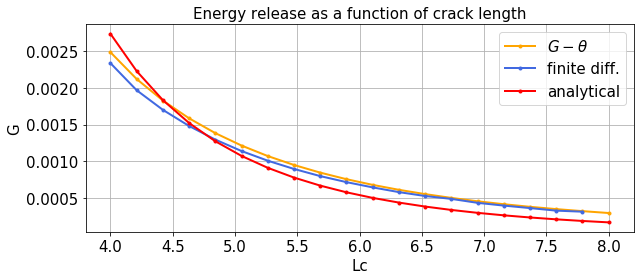

In [17]:
plt.figure(figsize=(9,4))

plt.plot(l, G_theta, '.-', lw=2, color='orange', label=r'$G-\theta$')
plt.plot(l[:-1], G_finite_difference, '.-', lw=2, color='royalblue', label='finite diff.')
plt.plot(l, G_ana, '.-', lw=2, color='red', label='analytical')

plt.title('Energy release as a function of crack length', size=15)
plt.ylabel('G', size=15)
plt.xlabel('Lc', size=15)

plt.xticks(size=15)
plt.yticks(size=15)

plt.grid(True)
plt.legend(prop={'size':15})

plt.tight_layout()

# plt.savefig('fig G2.png')

### Q5

Using the result of the previous question and the results of Lecture 4:
 
 a - Is the crack propagation at imposed displacement stable? Why?
 
 b - Provide a dimensionless plot of the crack length as a function of the applied displacement.
 
 c - Plot the global force-displacement diagram
 
 d - Would the propagation be stable at imposed force? Justify your answer using the material of the course.


#### a 

As long as we ensure stability condition, at fixed displacement, we don't propagate crack.

#### b

Adimensionnate equation for L :
$$\bar{L} = \left(\frac{q}{q_c}\right)^2 \times \left(\frac{1}{8.G_c.coeff}\right)^{1/4}$$
with a physical multiplier $\left(E.b\right)^{1/4}.H$.

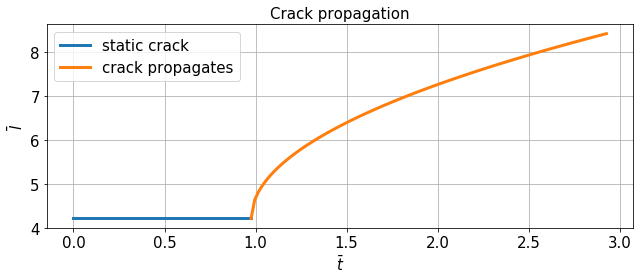

In [25]:
# Introduce, recall and define variables

idx = np.where(l > 4.)
Lc = l[idx[0][0]]       #where Lc close to 4.
Gc = G_theta[idx[0][0]] #associated value of G

# time vectors before and after crack propagation
tc_adim = (8 * coeff * Gc / H1**4)**(1/2) * Lc**2 # to be multiplied by q_c as tc_adim == t / q_c

n   = 3
N   = 100

# adim already : equivalent to q / q_c
t1  = np.linspace(0, tc_adim, N)
t2  = np.linspace(tc_adim, n*tc_adim, N)

# BEFORE propagation
l_0 = np.array([Lc for _ in range(len(t1))])

# AFTER propagation
l_t = (1 / (8 * Gc * coeff))**(1/4) * t1**(1/2) + Lc # to be multiplied by H1

plt.figure(figsize=(9,4))

plt.plot(t1, l_0, '-', lw=3, label='static crack')
plt.plot(t2, l_t, '-', lw=3, label='crack propagates')

plt.title('Crack propagation', size=15)
plt.ylabel(r'$\bar{l}$', size=15)
plt.xlabel(r'$\bar{t}$', size=15)

plt.xticks(size=15)
plt.yticks(size=15)

plt.grid(True)
plt.legend(prop={'size':15})

plt.tight_layout()

# plt.savefig('q_disp.png')

#### c

We have two phases as well to write down force as a function of displacement :
    
* $\frac{\partial P}{\partial F} = q$ provides a first relation
* the stability condition $G=G_c$ provides a second one (when crack propagates only)

It comes, with adimensionalisation :

* $\bar{Q_1} = \bar{t} \times \left(\frac{H}{l_0}\right)^3 \times \dfrac{1}{12.coeff}$ $\hspace{1.5cm} \rightarrow$ linear relation

with $\bar{t} = \frac{q}{q_c}$ and the physical multiplier is $E.b.q_c$.

* $\bar{Q_2} = \frac{1}{\sqrt{\bar{t}}} \times \dfrac{\left(8.G_c\right)^{3/4}}{12.coeff^{1/4}}$ $\hspace{.1cm} \rightarrow$ inverse square root

with once again $E.b.q_c$ as physical multiplier.

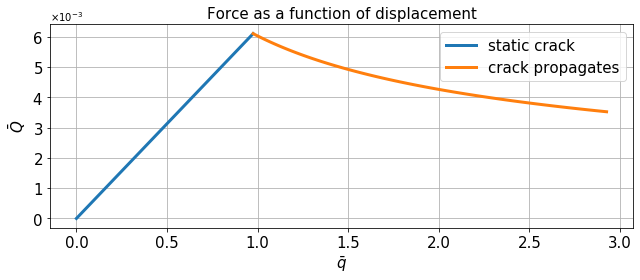

In [23]:
# Force as a function of displacement

F1 = t1            * (H1 / Lc)**3 / (12 * coeff) # to be mutliplied by E.b.q_c
F2 = 1/np.sqrt(t2) * (8*Gc)**(3/4) / (12 * coeff**(1/4)) # to be multiplied by E.b.q_c

fig, ax = plt.subplots(figsize=(9,4))

ax.plot(t1, F1, '-', lw=3, label='static crack')
ax.plot(t2, F2, '-', lw=3, label='crack propagates')

ax.set_title('Force as a function of displacement', size=15)
ax.set_ylabel(r'$\bar{Q}$', size=15)
ax.set_xlabel(r'$\bar{q}$', size=15)

plt.xticks(size=15)
plt.yticks(size=15)

plt.grid(True)
plt.legend(prop={'size':15})

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

plt.tight_layout()

# plt.savefig('Q_force.png')

We observe displacement of structure at lhs increases linearly with the force Q.

Then, once crack propagates, less force is needed to furthermore increase length crack. Physically, crack develops and it becomes easy to make crack furthermore propagate.

Eventually, we have a break such that beam is split in 2.

#### d

Again, as long as we ensure stability condition, even at fixed force, we don't propagate crack.

#### THE END